# Data analysis

## 1. Necessary imports

In [1]:
# to retrieve files
import os.path
# for mathematical calculations
import numpy as np
# for CSV and dataframe operations
import pandas as pd
# for plots
import matplotlib.pyplot as plt

## 2. Reading the data

In [2]:
# get the current working directory
print(os.getcwd())

C:\Users\berna\Google Drive\Work\Research_collab\Github_repositories\Vehicle_insurance_claim_fraud_detection\Jupyter_notebooks


In [3]:
# reading the dataset stored as CSV
data = pd.read_csv(os.getcwd() + '/../Dataset/fraud_oracle.csv')

# printing the first 5 rows of the dataframe
print(data.head())

  Month  WeekOfMonth  DayOfWeek    Make AccidentArea DayOfWeekClaimed  \
0   Dec            5  Wednesday   Honda        Urban          Tuesday   
1   Jan            3  Wednesday   Honda        Urban           Monday   
2   Oct            5     Friday   Honda        Urban         Thursday   
3   Jun            2   Saturday  Toyota        Rural           Friday   
4   Jan            5     Monday   Honda        Urban          Tuesday   

  MonthClaimed  WeekOfMonthClaimed     Sex MaritalStatus  ...  AgeOfVehicle  \
0          Jan                   1  Female        Single  ...       3 years   
1          Jan                   4    Male        Single  ...       6 years   
2          Nov                   2    Male       Married  ...       7 years   
3          Jul                   1    Male       Married  ...   more than 7   
4          Feb                   2  Female        Single  ...       5 years   

  AgeOfPolicyHolder PoliceReportFiled WitnessPresent AgentType  \
0          26 to 30 

## 3. Showing class imbalance

In [4]:
# get the value counts
data['FraudFound_P'].value_counts()

0    14497
1      923
Name: FraudFound_P, dtype: int64

In [5]:
# storing the value counts
vc = data.FraudFound_P.value_counts()

# convert the value counts to a list
list_vc = vc.tolist()
list_vc

# convert the value counts to another list
vc_numbers_list = vc.to_list()

# get the total number of claims in the dataset
total = data.shape[0]

# convert the value counts to percentage of the total number of claims
list_vc = [round(l/total * 100, 2) for l in list_vc]
list_vc

[94.01, 5.99]

In [6]:
# getting the labels
s = vc.index.tolist()
s

[0, 1]

In [7]:
# setting new labels for plotting purposes only
s = ['Non_fraudulent', 'Fraudulent']

In [8]:
# setting the x-axis
yax = [text + ', ' + str(occ) + ', ' + str(perc) + '%' for text, occ, perc in zip(s, vc_numbers_list, list_vc)]
yax

['Non_fraudulent, 14497, 94.01%', 'Fraudulent, 923, 5.99%']

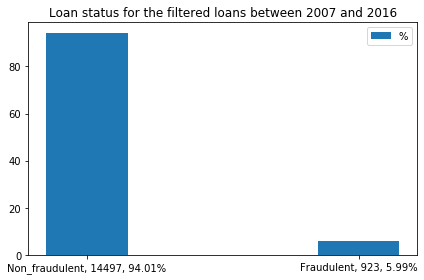

In [9]:
ticks = yax
data_for_plotting = list_vc
ind = np.arange(len(data_for_plotting))
fig = plt.figure(tight_layout=True) # need tight_layout to make everything fit
ax = plt.subplot(111)
ax.bar(ind, data_for_plotting, 0.3, align='center', label="%")
plt.legend()
plt.title('Fradulent and non-fradulent vehicle insurance claims')
y_pos = range(len(yax))
plt.xticks(y_pos, yax)
plt.draw()  # this is needed because get_window_extent needs a renderer to work
plt.savefig('graphs/claims_labels.png')
plt.draw()
plt.show()